In [ ]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import os
import subprocess
import xarray as xr

import troute.nhd_io as nhd_io
import troute.nhd_network as nhd_network
import troute.nhd_network_utilities_v02 as nnu
#import troute.routing.diffusive_utils as diff_utils
import troute.routing.diffusive_utils_mainstem_naturalxsec as diff_utils
                      

# load MC simulation results, which will be used for initial and boundary conditions
#chrtout_folder = pathlib.Path("/glade/work/adamw/forcing/florence_event")
chrtout_folder = pathlib.Path("/home/APD/inland_hydraulics/florence_testcase/glade/work/jamesmcc/domains/private/florence_v21/FORCING_AnA_channel-only")
chrtout_files = sorted(chrtout_folder.glob("*CHRTOUT_DOMAIN1"))

with xr.open_mfdataset(
    chrtout_files, 
    combine="nested",
    concat_dim="time"
) as ds:
    
    #  lateral inflows (WRF - generated)
    q_lateral = pd.DataFrame(
        ds['qBucket'].values.T + ds['qSfcLatRunoff'].values.T,
        index=ds['feature_id'].values,
        columns=ds.time.values,
    )
    
    # wrf simulated flow (WRF - generated)
    q_wrf = pd.DataFrame(
        ds['streamflow'].values.T,
        index=ds['feature_id'].values,
        columns=ds.time.values,
    )
    
# Hand-selected segments along the Cape Fear River between gages at Tar Heel and Kelly 
#diffusive_domain = [8831712,8831726,8831730,8831734,8831736,8831748,8831754,8831752,8831780,8831794,8831792,8831798,8831808,8831810,8831806,
#                    8831818,8831820,8831826,8831830,8831832,8831840,8831846,8831848,8831852,8831858,8834892,8834894,8834898,8834904,8834908,
#                    8834912,8834918,8834924]

diffusive_domain = [8831712,8831726,8831730] # only headsegments of reaches on a mainstem.


#args = nhd_io.read_custom_input_new("/glade/u/home/adamw/projects/t-route/test/jobs/V03/Cape_Fear_test_MC_V3.yaml")
args = nhd_io.read_custom_input_new("/home/dongha.kim/github/t-route/test/input/yaml/Cape_Fear_test_MC_V3.yaml")
supernetwork_parameters = args[2]

In [ ]:
# for diagnosis
#diff_utils
dir(diff_utils)

In [ ]:
connections, param_df, _, _ = nnu.build_connections(
        supernetwork_parameters
    )

rconn = nhd_network.reverse_network(connections)

# identify the tributary segments to the diffusive domain
trib_segs = []
for s in diffusive_domain:
    us_list = rconn[s]
    for u in us_list:
        if u not in diffusive_domain:
            trib_segs.append(u)

connections_trim = {k: connections[k] for k in (diffusive_domain + trib_segs)}
connections_trim[8831730]=[]  ## temporary fix to make proper TW link.
network_break_segments = set()
independent_networks, reaches_bytw, rconn = nnu.organize_independent_networks(
        connections_trim,
        network_break_segments,
    )

tw = list(nhd_network.headwaters(rconn))[0]
reach_list=reaches_bytw[tw]
rconn=independent_networks[tw]
connections_trim= nhd_network.reverse_network(rconn)
mainstem_headseg_list= diffusive_domain


diffusive_trib_domain=list(set(diffusive_domain)|set(trib_segs))
# mask channel geometry data
param_df_sub= param_df.loc[
                        diffusive_trib_domain,
                        ["bw", "tw", "twcc", "dx", "n", "ncc", "cs", "s0", "alt"],
                    ].sort_index()
geo_cols = param_df_sub.columns.values
geo_index = param_df_sub.index.values
geo_data = param_df_sub.values

# build initial conditions array
q0 = q_wrf.loc[geo_index].iloc[:,0].to_numpy()
q0_2 = [[val] for val in q0]
initial_conditions = np.asarray(q0_2)

# lateral inflow data
qlat_data = q_lateral.loc[geo_index].to_numpy()
# MC data
q_wrf_data= q_wrf.loc[geo_index].to_numpy()

import yaml
custom_input_file='../../../../test/input/yaml/Florence_Benchmark_diff.yaml'
with open(custom_input_file) as custom_file:
    data = yaml.load(custom_file, Loader=yaml.SafeLoader)
diffusive_parameters = data.get("diffusive_parameters", {})  
upstream_results={}
lake_segs=[]
waterbodies_df_sub = pd.DataFrame()
waterbodies_df_sub.values
lake_segs=np.asarray(lake_segs)
wbody_params=np.array(waterbodies_df_sub.values)
qts_subdivisions=12
nsteps=288
dt=60 

In [ ]:
# for diagnosis
geo_index
print(len(mainstem_headseg_list))

In [ ]:
# prepare environment for natural x-sec bathy data passing from Python to Fortran diffusive kernel

import netCDF4 as nc
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

RouteLinkNC = nc.Dataset('/home/dongha.kim/github/t-route/src/python_routing_v02/troute/routing/RouteLink_CONUS.nc')
inland_bathyNC = nc.Dataset('/home/dongha.kim/github/t-route/src/python_routing_v02/troute/routing/eHydro_ned_cross_sections_2021_11_22.nc')
# The current eHydro data doesn't cover Cape fear river, so for pure testing purpose we borrow 
# three x-sec bathy data from arbitarily picked three segments (they are connected in series)
comid_bathy = np.unique(inland_bathyNC['comid'][:])[1:4]
print(comid_bathy)
'''
inland_bathyDF = pd.DataFrame()
inland_bathyDF['comid'] =  pd.DataFrame(np.ma.filled(inland_bathyNC['comid'][:]))
# this is lateral distance from x=0 where the NWM line crosses the cross section later line. 
# For left side of x=0 (when looking upstream-to-downstream), the lateral distance takes negative values 
# for left side of main channel or left floodplains whiel positive for right side of main ch. or right floodplains.
inland_bathyDF['x_bathy'] =  pd.DataFrame(np.ma.filled(inland_bathyNC['xid_d'][:]))
inland_bathyDF['z_bathy'] =   pd.DataFrame(np.ma.filled(inland_bathyNC['z'][:]))

# find maximum size of x or z bathy data
# test
mxncomp_g=2
nrch_g=3
size_bathy_g= np.zeros((mxncomp_g, nrch_g), dtype=int)
sizelist=[]
for i in range(0,3): # for bathy data of arbitarily selected three segments
    inland_bathyDF_subset = inland_bathyDF[inland_bathyDF['comid'] == comid_bathy[i]]    
    size= inland_bathyDF_subset['x_bathy'].size
    sizelist.append(size)
    size_bathy_g[1,i]=size

maxsize=max(sizelist)
        
x_bathy_g = np.zeros((maxsize, mxncomp_g, nrch_g))
z_bathy_g = np.zeros((maxsize, mxncomp_g, nrch_g))

for idx_comid in range(0,3):
    inland_bathyDF_subset = inland_bathyDF[inland_bathyDF['comid'] == comid_bathy[idx_comid]]
    for idp in range(0,size_bathy_g[1,idx_comid]):
        x_bathy_g[idp,1,idx_comid]  = inland_bathyDF_subset [['x_bathy']].iloc[idp]
        z_bathy_g[idp,1,idx_comid] =  inland_bathyDF_subset [['z_bathy']].iloc[idp]
'''    


In [ ]:
#x_bathy_g[:,1,2]
#z_bathy_g[:,1,2]
reach_list

In [ ]:
diff_inputs= diff_utils.diffusive_input_data_v01(
    tw,
    connections_trim,
    rconn,
    reach_list,
    mainstem_headseg_list,
    q_wrf_data,    
    diffusive_parameters,
    geo_cols,
    geo_index,
    geo_data,
    qlat_data,
    initial_conditions,
    upstream_results,
    qts_subdivisions,
    nsteps,
    dt,
    lake_segs,
    wbody_params,
    comid_bathy,
    inland_bathyNC,
)




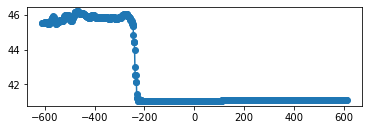

In [19]:
import matplotlib.pyplot as plt
x_bathy_g= diff_inputs["x_bathy_g"]
z_bathy_g= diff_inputs["z_bathy_g"]
size_bathy_g= diff_inputs["size_bathy_g"]
mxnbathy_g= diff_inputs["mxnbathy_g"]
#x = inland_bathy_cross_sections_subset[['xid_d']]
#y = inland_bathy_cross_sections_subset[['z']]
x=[]
y=[]
for idp in range(0, size_bathy_g[1, 6]):
    x.append(x_bathy_g[idp, 1, 6])
    y.append(z_bathy_g[idp, 1, 6])

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x,y)
ax.plot(x,y)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

plt.show()

In [24]:
import cnt_mstem_nx as cnt

timestep_ar_g= diff_inputs["timestep_ar_g"]
nts_ql_g= diff_inputs["nts_ql_g"] 
nts_ub_g= diff_inputs["nts_ub_g"]
nts_db_g= diff_inputs["nts_db_g"] 
ntss_ev_g= diff_inputs["ntss_ev_g"]
nts_qtrib_g= diff_inputs["nts_qtrib_g"]   
mxncomp_g= diff_inputs["mxncomp_g"] 
nrch_g= diff_inputs["nrch_g"] 
z_ar_g=  diff_inputs["z_ar_g"] 
bo_ar_g=  diff_inputs["bo_ar_g"] 
traps_ar_g= diff_inputs["traps_ar_g"] 
tw_ar_g=  diff_inputs["tw_ar_g"] 
twcc_ar_g= diff_inputs["twcc_ar_g"] 
mann_ar_g= diff_inputs["mann_ar_g"] 
manncc_ar_g= diff_inputs["manncc_ar_g"] 
so_ar_g= diff_inputs["so_ar_g"] 
dx_ar_g= diff_inputs["dx_ar_g"]
frnw_col= diff_inputs["frnw_col"] 
dfrnw_g= diff_inputs["frnw_g"] 
qlat_g= diff_inputs["qlat_g"] 
ubcd_g= diff_inputs["ubcd_g"] 
dbcd_g= diff_inputs["dbcd_g"]   
qtrib_g= diff_inputs["qtrib_g"]     
paradim= diff_inputs["paradim"] 
para_ar_g= diff_inputs["para_ar_g"]   
iniq= diff_inputs["iniq"] 

x_bathy_g= diff_inputs["x_bathy_g"] 
z_bathy_g= diff_inputs["z_bathy_g"]
size_bathy_g= diff_inputs["size_bathy_g"] 
mxnbathy_g= diff_inputs["mxnbathy_g"]
q_ev_g=np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
elv_ev_g= np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
#import pdb; pdb.set_trace()



In [26]:
print(cnt.diffusive.diffnw.__doc__)

q_ev_g,elv_ev_g = diffnw(timestep_ar_g,ntss_ev_g,z_ar_g,bo_ar_g,traps_ar_g,tw_ar_g,twcc_ar_g,mann_ar_g,manncc_ar_g,so_ar_g,dx_ar_g,iniq,dfrnw_g,qlat_g,ubcd_g,dbcd_g,qtrib_g,para_ar_g,x_bathy_g,z_bathy_g,size_bathy_g,[nts_ql_g,nts_ub_g,nts_db_g,nts_qtrib_g,mxncomp_g,nrch_g,frnw_col,paradim,mxnbathy_g])

Wrapper for ``diffnw``.

Parameters
----------
timestep_ar_g : input rank-1 array('d') with bounds (f2py_timestep_ar_g_d0)
ntss_ev_g : input int
z_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
bo_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
traps_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
tw_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
twcc_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
mann_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
manncc_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
so_ar_g : input rank-2 array('d') with bounds (mxncomp_g,nrch_g)
dx_ar_g : input rank-

In [27]:
q_ev_g, elv_ev_g = cnt.diffusive.diffnw(timestep_ar_g, 
                                            ntss_ev_g,
                                            z_ar_g, 
                                            bo_ar_g, 
                                            traps_ar_g, 
                                            tw_ar_g, 
                                            twcc_ar_g, 
                                            mann_ar_g, 
                                            manncc_ar_g, 
                                            so_ar_g, 
                                            dx_ar_g, 
                                            iniq, 
                                            dfrnw_g, 
                                            qlat_g, 
                                            ubcd_g, 
                                            dbcd_g, 
                                            qtrib_g,
                                            para_ar_g,
                                            x_bathy_g,
                                            z_bathy_g,
                                            size_bathy_g,                                        
                                            nts_ql_g, 
                                            nts_ub_g,                                           
                                            nts_db_g, 
                                            nts_qtrib_g, 
                                            mxncomp_g, 
                                            nrch_g,                                            
                                            frnw_col, 
                                            paradim,
                                            mxnbathy_g
                                            )

 depth at d/s   1.0729286330859367     
 depth at d/s   9.6877294452369256E-002
 depth at d/s   8.8342837814728625E-002
 depth at d/s   8.2092195420003122E-002
 depth at d/s   7.6292946053293065E-002
 depth at d/s   7.0860340210238348E-002
 depth at d/s   5.8228923450997172E-002
 depth at d/s   5.5625948240489720E-002
 depth at d/s   5.2972518453827888E-002
 depth at d/s   5.0587388892857632E-002
 depth at d/s   4.8286038609305137E-002
 depth at d/s   4.6073019027403461E-002
 depth at d/s   4.3964246405131746E-002
 depth at d/s   4.1983903157905900E-002
 depth at d/s   4.0035455494752625E-002
 depth at d/s   3.7433466703866713E-002
 depth at d/s   3.5165460165096363E-002
 depth at d/s   3.4040345086317814E-002
 depth at d/s   3.3083814831975644E-002
 depth at d/s   3.2092091249111832E-002
 depth at d/s   3.1481903288117508E-002
 depth at d/s   3.0954557382926851E-002
 depth at d/s   3.0576789025793971E-002
 depth at d/s   3.0338089377707433E-002
 depth at d/s   3.0249825407025810E-002


In [ ]:

np.savetxt("./output/q[1]_cnx.txt", q_ev_g[1], fmt='%15.5f')
#q_ev_g[1]
np.savetxt("./output/q[6]_cnx.txt", q_ev_g[1], fmt='%15.5f')
q_ev_g[:,:,1]

In [ ]:
import cnmod

timestep_ar_g= diff_inputs["timestep_ar_g"]
nts_ql_g= diff_inputs["nts_ql_g"] 
nts_ub_g= diff_inputs["nts_ub_g"]
nts_db_g= diff_inputs["nts_db_g"] 
ntss_ev_g= diff_inputs["ntss_ev_g"]
nts_qtrib_g= diff_inputs["nts_qtrib_g"]   
mxncomp_g= diff_inputs["mxncomp_g"] 
nrch_g= diff_inputs["nrch_g"] 
z_ar_g=  diff_inputs["z_ar_g"] 
bo_ar_g=  diff_inputs["bo_ar_g"] 
traps_ar_g= diff_inputs["traps_ar_g"] 
tw_ar_g=  diff_inputs["tw_ar_g"] 
twcc_ar_g= diff_inputs["twcc_ar_g"] 
mann_ar_g= diff_inputs["mann_ar_g"] 
manncc_ar_g= diff_inputs["manncc_ar_g"] 
so_ar_g= diff_inputs["so_ar_g"] 
dx_ar_g= diff_inputs["dx_ar_g"]
frnw_col= diff_inputs["frnw_col"] 
dfrnw_g= diff_inputs["frnw_g"] 
qlat_g= diff_inputs["qlat_g"] 
ubcd_g= diff_inputs["ubcd_g"] 
dbcd_g= diff_inputs["dbcd_g"]   
qtrib_g= diff_inputs["qtrib_g"]     
paradim= diff_inputs["paradim"] 
para_ar_g= diff_inputs["para_ar_g"]   
iniq= diff_inputs["iniq"] 

q_ev_g=np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
elv_ev_g= np.zeros((ntss_ev_g, mxncomp_g, nrch_g))

In [ ]:
q_ev_g, elv_ev_g = cnmod.diffusive.diffnw(timestep_ar_g, 
                                            ntss_ev_g,
                                            z_ar_g, 
                                            bo_ar_g, 
                                            traps_ar_g, 
                                            tw_ar_g, 
                                            twcc_ar_g, 
                                            mann_ar_g, 
                                            manncc_ar_g, 
                                            so_ar_g, 
                                            dx_ar_g, 
                                            iniq, 
                                            dfrnw_g, 
                                            qlat_g, 
                                            ubcd_g, 
                                            dbcd_g, 
                                            qtrib_g,
                                            para_ar_g,
                                            nts_ql_g, 
                                            nts_ub_g,                                           
                                            nts_db_g, 
                                            nts_qtrib_g, 
                                            mxncomp_g, 
                                            nrch_g,                                            
                                            frnw_col, 
                                            paradim 
                                            )

In [ ]:
q_ev_g


In [ ]:
import cnt_mainstem as cnt

timestep_ar_g= diff_inputs["timestep_ar_g"]
nts_ql_g= diff_inputs["nts_ql_g"] 
nts_ub_g= diff_inputs["nts_ub_g"]
nts_db_g= diff_inputs["nts_db_g"] 
ntss_ev_g= diff_inputs["ntss_ev_g"]
nts_qtrib_g= diff_inputs["nts_qtrib_g"]   
mxncomp_g= diff_inputs["mxncomp_g"] 
nrch_g= diff_inputs["nrch_g"] 
z_ar_g=  diff_inputs["z_ar_g"] 
bo_ar_g=  diff_inputs["bo_ar_g"] 
traps_ar_g= diff_inputs["traps_ar_g"] 
tw_ar_g=  diff_inputs["tw_ar_g"] 
twcc_ar_g= diff_inputs["twcc_ar_g"] 
mann_ar_g= diff_inputs["mann_ar_g"] 
manncc_ar_g= diff_inputs["manncc_ar_g"] 
so_ar_g= diff_inputs["so_ar_g"] 
dx_ar_g= diff_inputs["dx_ar_g"]
frnw_col= diff_inputs["frnw_col"] 
dfrnw_g= diff_inputs["frnw_g"] 
qlat_g= diff_inputs["qlat_g"] 
ubcd_g= diff_inputs["ubcd_g"] 
dbcd_g= diff_inputs["dbcd_g"]   
qtrib_g= diff_inputs["qtrib_g"]     
paradim= diff_inputs["paradim"] 
para_ar_g= diff_inputs["para_ar_g"]   
iniq= diff_inputs["iniq"] 

q_ev_g=np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
elv_ev_g= np.zeros((ntss_ev_g, mxncomp_g, nrch_g))

In [ ]:
q_ev_g, elv_ev_g = cnt.diffusive.diffnw(timestep_ar_g, 
                                            ntss_ev_g,
                                            z_ar_g, 
                                            bo_ar_g, 
                                            traps_ar_g, 
                                            tw_ar_g, 
                                            twcc_ar_g, 
                                            mann_ar_g, 
                                            manncc_ar_g, 
                                            so_ar_g, 
                                            dx_ar_g, 
                                            iniq, 
                                            dfrnw_g, 
                                            qlat_g, 
                                            ubcd_g, 
                                            dbcd_g, 
                                            qtrib_g,
                                            para_ar_g,
                                            nts_ql_g, 
                                            nts_ub_g,                                           
                                            nts_db_g, 
                                            nts_qtrib_g, 
                                            mxncomp_g, 
                                            nrch_g,                                            
                                            frnw_col, 
                                            paradim 
                                            )

In [ ]:
q_ev_g
elv_ev_g


In [ ]:
'''
import cnmod 
cnmod.var.timestep_ar_g= diff_inputs["timestep_ar_g"]
cnmod.var.nts_ql_g= diff_inputs["nts_ql_g"] 
cnmod.var.nts_ub_g= diff_inputs["nts_ub_g"]
cnmod.var.nts_db_g= diff_inputs["nts_db_g"] 

cnmod.var.nts_qtrib_g= diff_inputs["nts_qtrib_g"]   

cnmod.var.z_ar_g=  diff_inputs["z_ar_g"] 
cnmod.var.bo_ar_g=  diff_inputs["bo_ar_g"] 
cnmod.var.traps_ar_g= diff_inputs["traps_ar_g"] 
cnmod.var.tw_ar_g=  diff_inputs["tw_ar_g"] 
cnmod.var.twcc_ar_g= diff_inputs["twcc_ar_g"] 
cnmod.var.mann_ar_g= diff_inputs["mann_ar_g"] 
cnmod.var.manncc_ar_g= diff_inputs["manncc_ar_g"] 
cnmod.var.so_ar_g= diff_inputs["so_ar_g"] 
cnmod.var.dx_ar_g= diff_inputs["dx_ar_g"]
cnmod.var.frnw_col= diff_inputs["frnw_col"] 
cnmod.var.dfrnw_g= diff_inputs["frnw_g"] 
cnmod.var.qlat_g= diff_inputs["qlat_g"] 
cnmod.var.ubcd_g= diff_inputs["ubcd_g"] 
cnmod.var.dbcd_g= diff_inputs["dbcd_g"]   
cnmod.var.qtrib_g= diff_inputs["qtrib_g"]     
cnmod.var.paradim= diff_inputs["paradim"] 
cnmod.var.para_ar_g= diff_inputs["para_ar_g"]   
cnmod.var.iniq= diff_inputs["iniq"] 

ntss_ev_g= diff_inputs["ntss_ev_g"]
mxncomp_g= diff_inputs["mxncomp_g"] 
nrch_g= diff_inputs["nrch_g"] 

q_ev_g=np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
elv_ev_g= np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
#import pdb; pdb.set_trace()
q_ev_g, elv_ev_g = cnmod.diffusive.diffnw(ntss_ev_g, mxncomp_g, nrch_g)
'''

In [ ]:
'''
import cnx_mstem_2 as cnx2
import numpy as np
cnx2.var.timestep_ar_g=np.zeros(8)
cnx2.var.timestep_ar_g= diff_inputs["timestep_ar_g"]
cnx2.var.nts_ql_g= diff_inputs["nts_ql_g"] 
cnx2.var.nts_ub_g= diff_inputs["nts_ub_g"]
cnx2.var.nts_db_g= diff_inputs["nts_db_g"] 
cnx2.var.nts_qtrib_g= diff_inputs["nts_qtrib_g"]   

mxncomp_g= diff_inputs["mxncomp_g"] 
nrch_g= diff_inputs["nrch_g"]

cnx2.var.z_ar_g=   np.zeros((mxncomp_g, nrch_g))
cnx2.var.bo_ar_g=   np.zeros((mxncomp_g, nrch_g))
cnx2.var.traps_ar_g=  np.zeros((mxncomp_g, nrch_g))
cnx2.var.tw_ar_g=   np.zeros((mxncomp_g, nrch_g))
cnx2.var.twcc_ar_g=  np.zeros((mxncomp_g, nrch_g))
cnx2.var.mann_ar_g=  np.zeros((mxncomp_g, nrch_g))
cnx2.var.manncc_ar_g=  np.zeros((mxncomp_g, nrch_g))
cnx2.var.so_ar_g=  np.zeros((mxncomp_g, nrch_g))
cnx2.var.dx_ar_g=  np.zeros((mxncomp_g, nrch_g))

cnx2.var.z_ar_g=  diff_inputs["z_ar_g"] 
cnx2.var.bo_ar_g=  diff_inputs["bo_ar_g"] 
cnx2.var.traps_ar_g= diff_inputs["traps_ar_g"] 
cnx2.var.tw_ar_g=  diff_inputs["tw_ar_g"] 
cnx2.var.twcc_ar_g= diff_inputs["twcc_ar_g"] 
cnx2.var.mann_ar_g= diff_inputs["mann_ar_g"] 
cnx2.var.manncc_ar_g= diff_inputs["manncc_ar_g"] 
cnx2.var.so_ar_g= diff_inputs["so_ar_g"] 
cnx2.var.dx_ar_g= diff_inputs["dx_ar_g"]

cnx2.var.frnw_col= diff_inputs["frnw_col"] 
frnw_col= diff_inputs["frnw_col"] 
cnx2.var.dfrnw_g=  np.zeros((nrch_g, frnw_col))
cnx2.var.dfrnw_g= diff_inputs["frnw_g"] 
                             
nts_ql_g= diff_inputs["nts_ql_g"] 
cnx2.var.qlat_g = np.zeros((nts_ql_g, mxncomp_g, nrch_g))
cnx2.var.qlat_g= diff_inputs["qlat_g"] 

nts_ub_g= diff_inputs["nts_ub_g"]
cnx2.var.ubcd_g = np.zeros((nts_ub_g, nrch_g))                             
cnx2.var.ubcd_g= diff_inputs["ubcd_g"] 
                             
nts_db_g= diff_inputs["nts_db_g"]
cnx2.var.dbcd_g = np.zeros(nts_db_g)                             
cnx2.var.dbcd_g= diff_inputs["dbcd_g"] 
                             
nts_qtrib_g= diff_inputs["nts_qtrib_g"] 
cnx2.var.qtrib_g = np.zeros((nts_qtrib_g, nrch_g))
cnx2.var.qtrib_g= diff_inputs["qtrib_g"]  
                             


cnx2.var.paradim= diff_inputs["paradim"] 
paradim= diff_inputs["paradim"]
cnx2.var.para_ar_g= np.zeros(paradim)
cnx2.var.para_ar_g= diff_inputs["para_ar_g"]   

cnx2.var.iniq = np.zeros((mxncomp_g, nrch_g))                             
cnx2.var.iniq= diff_inputs["iniq"] 

ntss_ev_g= diff_inputs["ntss_ev_g"]

q_ev_g=np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
elv_ev_g= np.zeros((ntss_ev_g, mxncomp_g, nrch_g))
#import pdb; pdb.set_trace()
q_ev_g, elv_ev_g = cnx2.diffusive.diffnw(ntss_ev_g, mxncomp_g, nrch_g)
'''